# CLV PREDICTION USING BG/NBD & GG MODEL FROM LIFETIMES PACKAGE

GET THE DATASET FROM:
https://archive.ics.uci.edu/dataset/502/online+retail+ii

In [1]:
# IMPORT ALL THE REQUIRED PACKAGES AT THE BEGINNING FOR BETTER VISIBILITY.

from datetime import datetime, timedelta, date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_history_alive


from scipy.stats import beta
from scipy.stats import gamma

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## **I. EXPLORATORY DATA ANALYSIS**

In [2]:
# READ DATASET.

df = pd.read_excel("./datasets/online_retail_II.xlsx", sheet_name = ["Year 2009-2010", "Year 2010-2011"])

df1 = df["Year 2009-2010"]
df2 = df["Year 2010-2011"]

df1.shape, df2.shape

((525461, 8), (541910, 8))

In [3]:
df = df1.append(df2)
df.shape

(1067371, 8)

In [4]:
df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom

In [5]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

**Attribute Information**

Invoice: Invoice number. A 6-digit integer uniquely assigned to each transaction.  
StockCode: Product code. A 5-6 alphanumeric value uniquely assigned to each product.  
Description: Product name.  
Quantity: The amount of product purchased per transaction.  
InvoiceDate: Invoice date and time. The day and time when a transaction was generated.  
Price: Product price per unit.  
CustomerID: A 5-digit int value uniquely assigned to each customer.  
Country: The name of the country where the customer resides.  

In [6]:
df.describe().apply(lambda s: s.apply('{0:.3f}'.format))

Quantity        Price Customer ID
count  1067371.000  1067371.000  824364.000
mean         9.939        4.649   15324.639
std        172.706      123.553    1697.464
min     -80995.000   -53594.360   12346.000
25%          1.000        1.250   13975.000
50%          3.000        2.100   15255.000
75%         10.000        4.150   16797.000
max      80995.000    38970.000   18287.000

In [7]:
# CHECK FOR NULL RECORDS.

df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [8]:
# CHECK FOR NULL VALUES IN "Customer ID".

df[df["Customer ID"].isnull()].shape

(243007, 8)

In [9]:
# REMOVE ROWS WHERE "Customer ID" IS NULL.

df = df[~df["Customer ID"].isnull()]
df.shape

(824364, 8)

In [10]:
# CHECK FOR NULL RECORDS AGAIN.

df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [11]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [12]:
# CONVERT "Customer ID" COL TO INT AND THEN STRING FROM FLOAT.

df["Customer ID"] = df["Customer ID"].astype(int).astype(str)

In [13]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
dtype: object

In [14]:
# CREATE A NEW COLUMN 'TotalPrice' BY MULTIPLYING 'Quantity' & 'Price'.

df['TotalPrice'] = df['Quantity'] * df['Price']
df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price Customer ID         Country  TotalPrice  
0 2009-12-01 07:45:00   6.95       13085  United Kingdom        83.4  
1 2009-12-01 07:45:00   6.75       13085  United Kingdom        81.0  
2 2009-12-01 07:45:00   6.75       13085  United Kingdom        81.0  
3 2009-12-01 07:45:00   2.10       13085  United Kingdom       100.8  
4 2009-12-01 07:45:00   1.25       13085  United Kingdom        30.0

In [15]:
# CHECK RECORDS BY COUNTRY.

df["Country"].value_counts()

United Kingdom          741301
Germany                  17624
EIRE                     16195
France                   14202
Netherlands               5140
Spain                     3811
Belgium                   3123
Switzerland               3064
Portugal                  2504
Australia                 1913
Channel Islands           1664
Italy                     1534
Norway                    1455
Sweden                    1345
Cyprus                    1176
Finland                   1049
Austria                    938
Denmark                    817
Greece                     663
Japan                      582
USA                        535
Poland                     535
Unspecified                524
United Arab Emirates       386
Singapore                  346
Israel                     324
Malta                      299
Iceland                    253
Canada                     228
Lithuania                  189
RSA                        123
Brazil                      94
Thailand

In [16]:
# CREATE A NEW DF BASED ON COUNTRY.

df_country = pd.DataFrame(df["Country"].value_counts())
print(df_country.shape)
df_country.head()

(41, 1)


Country
United Kingdom   741301
Germany           17624
EIRE              16195
France            14202
Netherlands        5140

In [17]:
df.shape[0]

824364

#### *RECORDS BY COUNTRY*

In [18]:
# PLOT RECORDS COUNT BY COUNTRY.

px.scatter(df_country, y = "Country", color = df_country.index)

In [19]:
print("Percentage of records from 'United Kingdom': ", round((df_country.loc["United Kingdom", "Country"] / df.shape[0]) * 100))

Percentage of records from 'United Kingdom':  90


*FROM THE ABOVE TWO OBSERVATIONS, IT IS CLEAR THAT MAJORITY OF THE DATASET **(ABOUT 90%)** IS FROM **UNITED KINGDOM**.*

In [20]:
df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price Customer ID         Country  TotalPrice  
0 2009-12-01 07:45:00   6.95       13085  United Kingdom        83.4  
1 2009-12-01 07:45:00   6.75       13085  United Kingdom        81.0  
2 2009-12-01 07:45:00   6.75       13085  United Kingdom        81.0  
3 2009-12-01 07:45:00   2.10       13085  United Kingdom       100.8  
4 2009-12-01 07:45:00   1.25       13085  United Kingdom        30.0

#### *AVERAGE UNIT PRICE BY COUNTRY*

In [21]:
# PLOT AVERAGE UNIT PRICE BY COUNTRY.

px.scatter(df.iloc[:, [5, 7]].groupby(["Country"]).mean(), y="Price", size="Price", title="Average Unit Price by Country")

*AS YOU CAN SEE IN THE ABOVE PLOT, **SINGAPORE** HAS THE **HIGHEST AVERAGE UNIT PRICE**.*

#### *UNIT PRICE DISTRIBUTION BY COUNTRY*

In [22]:
countries = df["Country"].unique()
len(countries)

41

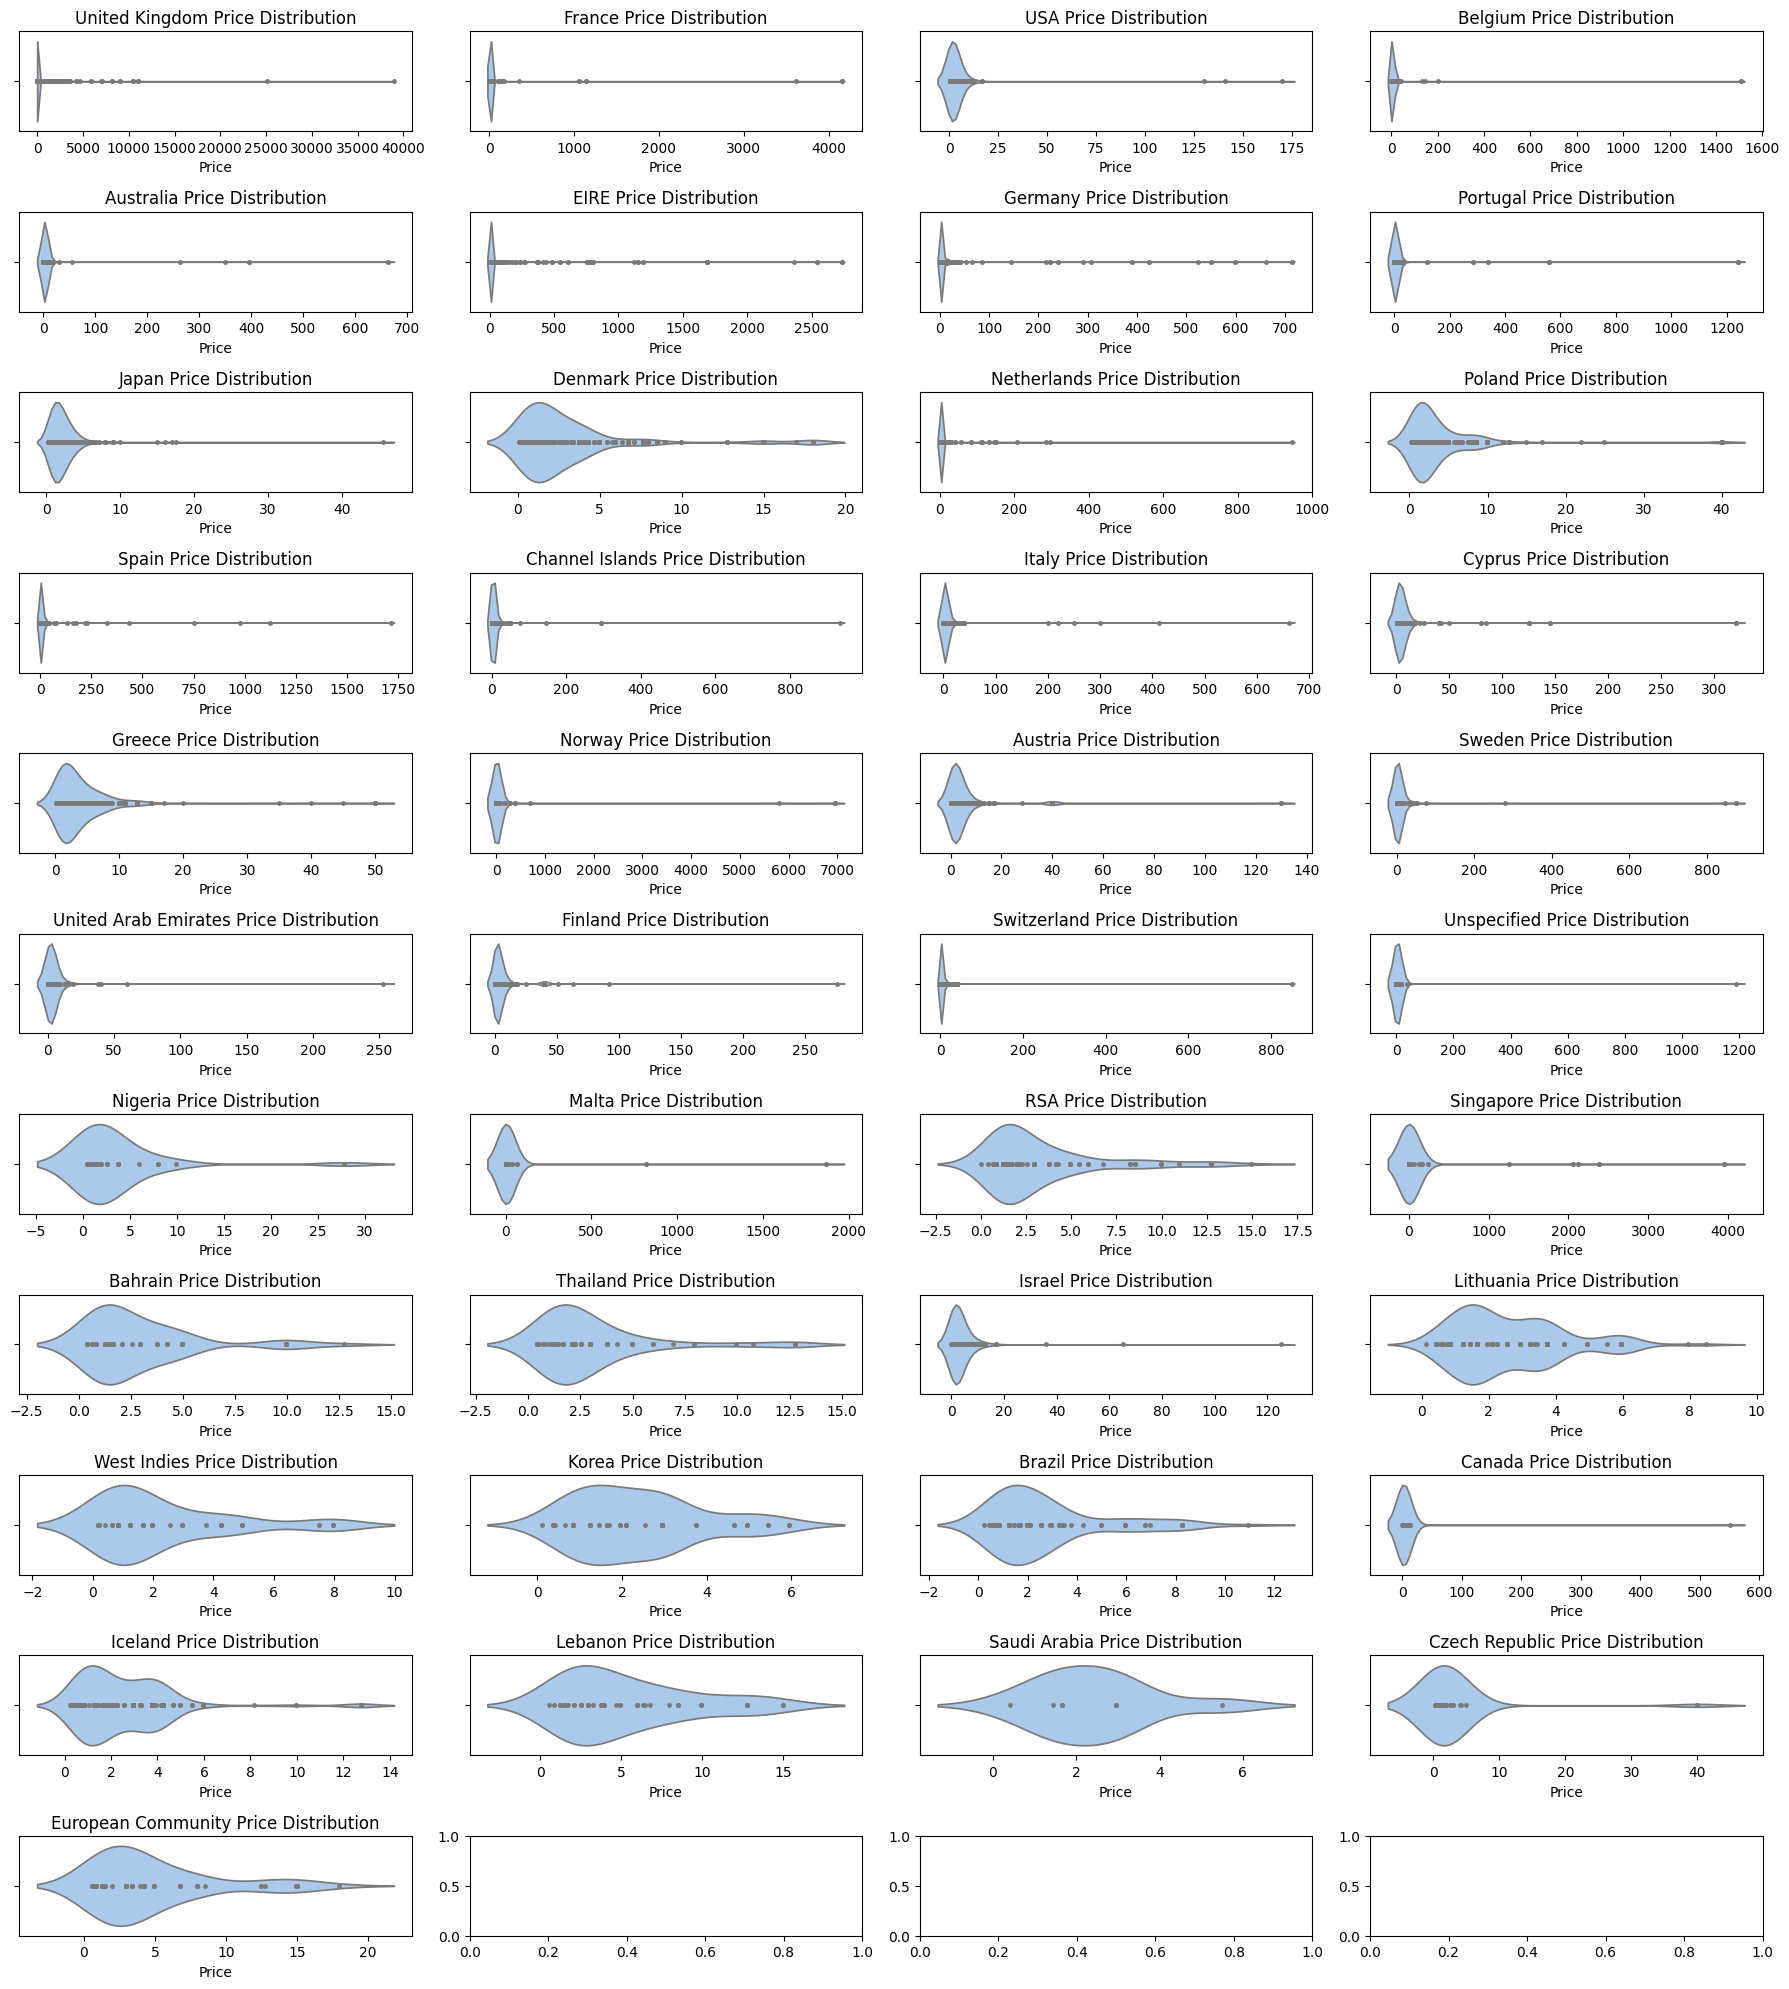

In [23]:
fig, ax = plt.subplots(11, 4, figsize=(18,20))
axes_ = [axes_row for axes in ax for axes_row in axes]

for i, c in enumerate(countries):
    sns.violinplot(x="Price", data=df[df["Country"]==c], ax=axes_[i], inner="point", palette="pastel")
    axes_[i].set_title(c + ' ' + "Price Distribution")
    plt.tight_layout()

#### *INVOICE & TOTAL PRICE*

In [24]:
df.head(3)

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   

          InvoiceDate  Price Customer ID         Country  TotalPrice  
0 2009-12-01 07:45:00   6.95       13085  United Kingdom        83.4  
1 2009-12-01 07:45:00   6.75       13085  United Kingdom        81.0  
2 2009-12-01 07:45:00   6.75       13085  United Kingdom        81.0

In [25]:
df.shape

(824364, 9)

In [26]:
# NUMBER OF UNIQUE INVOICES.

len(df["Invoice"].unique())

44876

In [27]:
invoice_df = df[["Invoice", "Quantity", "TotalPrice"]].groupby("Invoice").sum()
invoice_df.reset_index(inplace = True)
invoice_df.head()

Invoice  Quantity  TotalPrice
0  489434       166      505.30
1  489435        60      145.80
2  489436       193      630.33
3  489437       145      310.75
4  489438       826     2286.24

In [28]:
# TOP 30 INVOICES WITH TOTAL QUANTITY & TOTAL PRICE.

invoice_df.sort_values(by="TotalPrice", ascending=False).head(10)

Invoice  Quantity  TotalPrice
36942  581483     80995   168469.60
20348  541431     74215    77183.60
1604   493819     25018    44051.60
26365  556444        60    38970.00
13430  524181      8820    33167.80
19003  537659      7378    31770.98
30858  567423     12572    31698.16
14627  526934      5079    26007.08
10025  515944      4992    22863.36
26551  556917     15049    22775.93

In [29]:
df[df["Invoice"]==581483]

Invoice StockCode                  Description  Quantity  \
540421  581483     23843  PAPER CRAFT , LITTLE BIRDIE     80995   

               InvoiceDate  Price Customer ID         Country  TotalPrice  
540421 2011-12-09 09:15:00   2.08       16446  United Kingdom    168469.6

#### *TOP 20 MOST SOLD PRODUCT*

<Axes: xlabel='Description'>

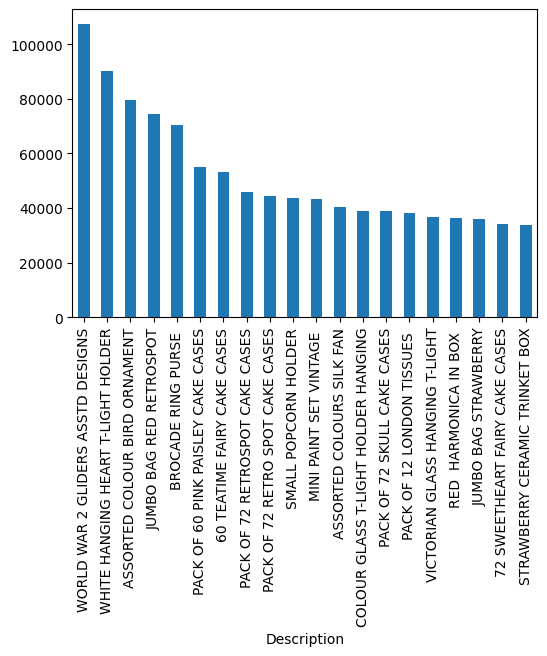

In [30]:
plt.figure(figsize=(6,4))
df.groupby("Description").sum().sort_values(by="Quantity", ascending=False).head(20)["Quantity"].plot(kind="bar")

#### *SALES BY CALENDER FEATURES*

In [31]:
df_copy = df.copy()

In [32]:
df_copy.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
TotalPrice            float64
dtype: object

In [33]:
df_copy["Month"] = df_copy["InvoiceDate"].dt.month
df_copy["Time"] = df_copy["InvoiceDate"].dt.time
df_copy["Year"] = df_copy["InvoiceDate"].dt.year
df_copy["Day"] = df_copy["InvoiceDate"].dt.day
df_copy["Day of Week"] = df_copy["InvoiceDate"].dt.dayofweek
df_copy["Day Name"] = df_copy["InvoiceDate"].dt.day_name()
df_copy["Quarter"] = df_copy["InvoiceDate"].dt.quarter

df_copy.sample(5)

Invoice StockCode                      Description  Quantity  \
253364  513791     22624             IVORY KITCHEN SCALES         1   
410842  572182     21916  SET 12 RETRO WHITE CHALK STICKS        24   
7381    490024     22065   CHRISTMAS PUDDING TRINKET POT          8   
130627  547498    17014A    ORIGAMI VANILLA INCENSE CONES         1   
159775  504623    85024C   PINK SMALL JEWELLED PHOTOFRAME         1   

               InvoiceDate  Price Customer ID         Country  TotalPrice  \
253364 2010-06-28 15:29:00   8.50       18036  United Kingdom        8.50   
410842 2011-10-21 10:32:00   0.42       13588  United Kingdom       10.08   
7381   2009-12-03 12:40:00   1.45       14606  United Kingdom       11.60   
130627 2011-03-23 12:24:00   1.65       15021  United Kingdom        1.65   
159775 2010-04-15 12:10:00   1.65       14656  United Kingdom        1.65   

        Month      Time  Year  Day  Day of Week   Day Name  Quarter  
253364      6  15:29:00  2010   28            0     Monday        2  
410842     10  10:32:00  2011   21            4     Friday        4  
7381       12  12:40:00  2009    3            3   Thursday        4  
130627      3  12:24:00  2011   23            2  Wednesday        1  
159775      4  12:10:00  2010   15            3   Thursday        2

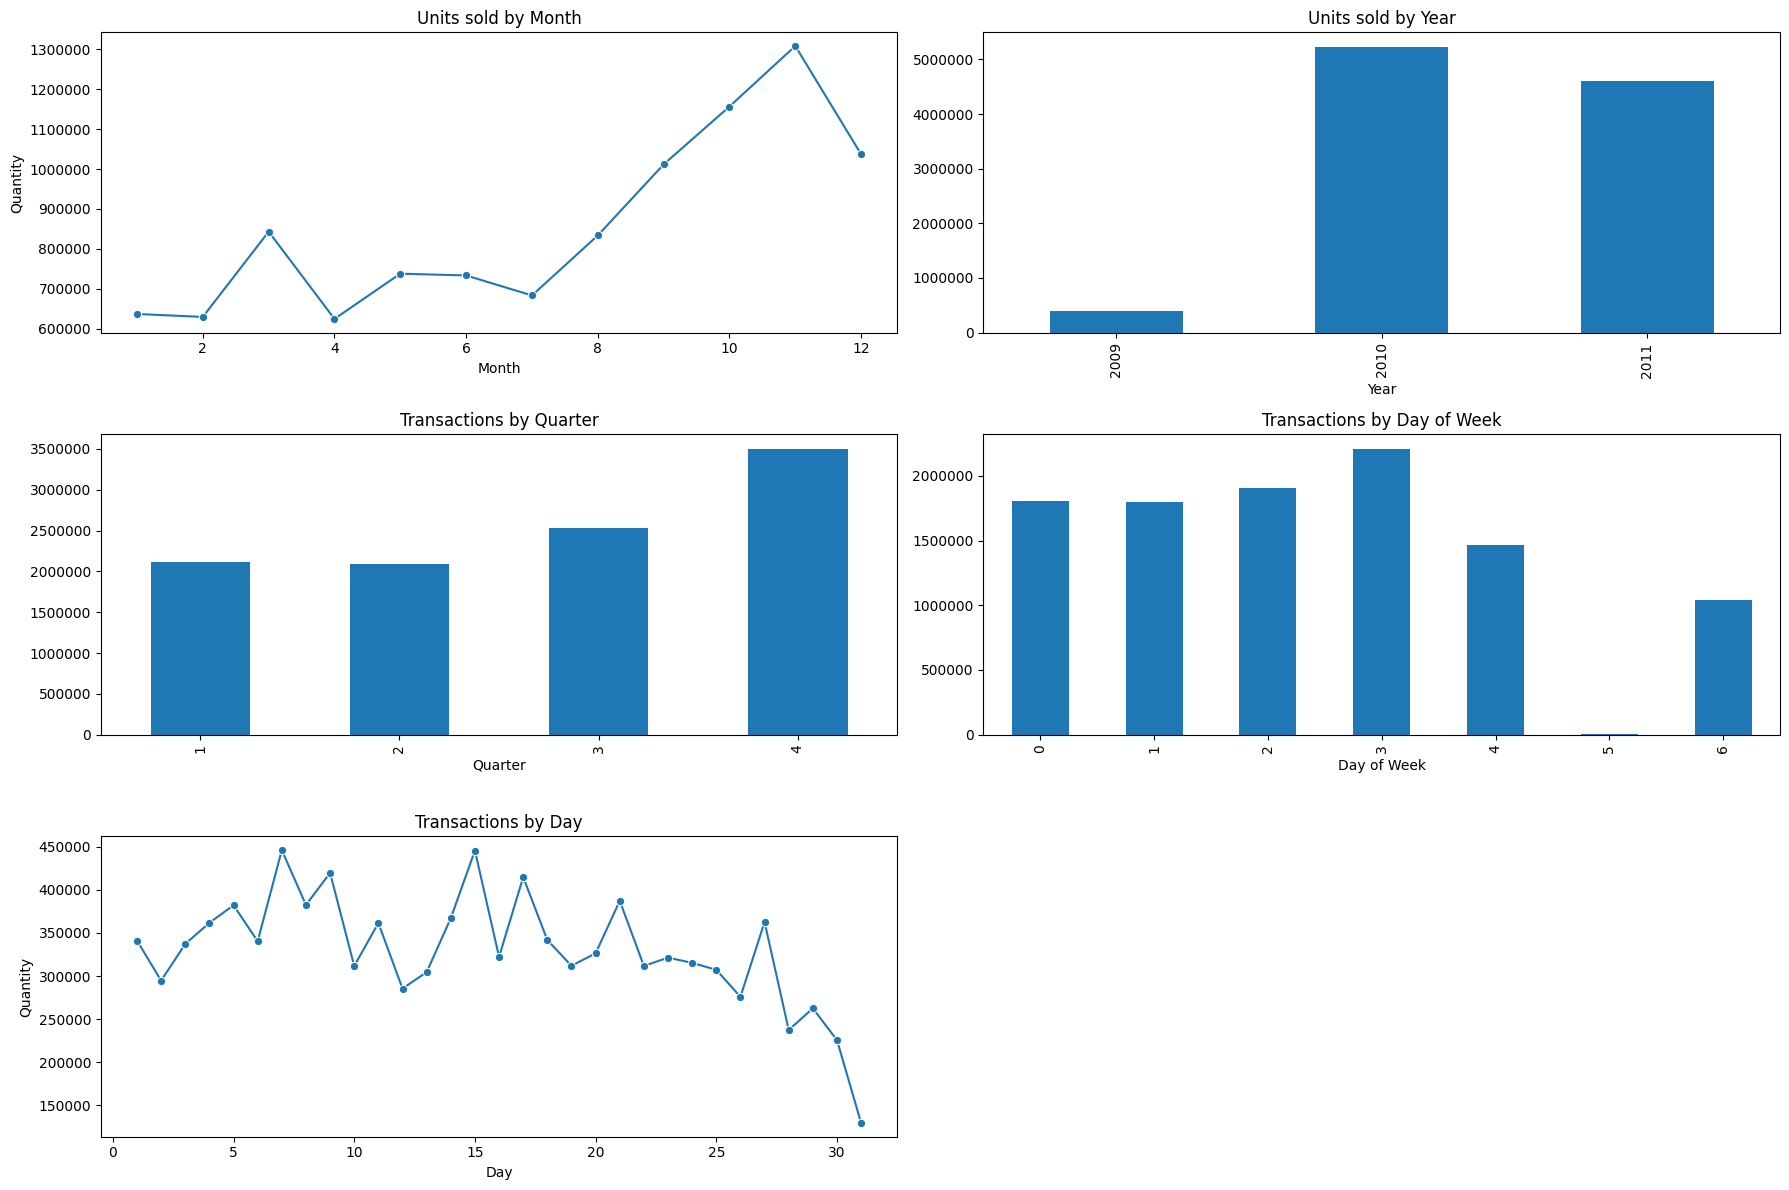

In [34]:
plt.figure(figsize=(18,12))

# PLOT FOR 'UNITS SOLD BY MONTH'
plt.subplot(3,2,1)
sns.lineplot(x="Month", y="Quantity", data=df_copy.groupby("Month").sum("Quantity"), marker="o")
plt.title("Units sold by Month")
plt.ticklabel_format(axis='y', style='plain')

# PLOT FOR 'UNITS SOLD BY YEAR'
plt.subplot(3,2,2)
df_copy.groupby("Year").sum()["Quantity"].plot(kind = "bar")
plt.title("Units sold by Year")
plt.ticklabel_format(axis='y', style='plain')

# PLOT FOR 'UNITS SOLD BY QUARTER'
plt.subplot(3,2,3)
df_copy.groupby("Quarter").sum()["Quantity"].plot(kind="bar")
plt.title("Transactions by Quarter")
plt.ticklabel_format(axis='y', style='plain')

# PLOT FOR 'UNITS SOLD BY DAY OF THE WEEK'
plt.subplot(3,2,4)
df_copy.groupby("Day of Week").sum()["Quantity"].plot(kind="bar")
plt.title("Transactions by Day of Week")
plt.ticklabel_format(axis='y', style='plain')

# PLOT FOR 'UNITS SOLD BY DAY'
plt.subplot(3,2,5)
sns.lineplot(x="Day", y="Quantity", data=df_copy.groupby("Day").sum("Quantity"), marker="o")
plt.title("Transactions by Day")
plt.ticklabel_format(axis='y', style='plain')

plt.tight_layout()
plt.show()

## **II. MODELLING**

### **Data Preparation**

In [35]:
df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price Customer ID         Country  TotalPrice  
0 2009-12-01 07:45:00   6.95       13085  United Kingdom        83.4  
1 2009-12-01 07:45:00   6.75       13085  United Kingdom        81.0  
2 2009-12-01 07:45:00   6.75       13085  United Kingdom        81.0  
3 2009-12-01 07:45:00   2.10       13085  United Kingdom       100.8  
4 2009-12-01 07:45:00   1.25       13085  United Kingdom        30.0

In [36]:
df["Country"].value_counts().head()

United Kingdom    741301
Germany            17624
EIRE               16195
France             14202
Netherlands         5140
Name: Country, dtype: int64

In [37]:
df.shape

(824364, 9)

In [38]:
# SELECT ONLY UK SINCE IT HAS THE MOST TRANSACTIONS.

df = df[df["Country"]=="United Kingdom"]
df.shape

(741301, 9)

In [39]:
# NUMBER OF UNIQUE CUSTOMERS.

len(df["Customer ID"].unique())

5410

In [40]:
# CHECK HOW MANY TRANSACTIONS IN 2009.

df[df["InvoiceDate"] < pd.to_datetime("2010-01-01")].shape

(29468, 9)

In [41]:
# SELECT ONLY TRANSACTIONS FROM 2010.

df = df[df["InvoiceDate"] >= pd.to_datetime("2010-01-01")]
df.shape

(711833, 9)

In [42]:
len(df["Customer ID"].unique())

5314

In [43]:
df.head()

Invoice StockCode                Description  Quantity  \
45228   493410   TEST001    This is a test product.         5   
45229  C493411     21539    RETRO SPOTS BUTTER DISH        -1   
45230   493412   TEST001    This is a test product.         5   
45234   493414     21844             RETRO SPOT MUG        36   
45235   493414     21533  RETRO SPOT LARGE MILK JUG        12   

              InvoiceDate  Price Customer ID         Country  TotalPrice  
45228 2010-01-04 09:24:00   4.50       12346  United Kingdom       22.50  
45229 2010-01-04 09:43:00   4.25       14590  United Kingdom       -4.25  
45230 2010-01-04 09:53:00   4.50       12346  United Kingdom       22.50  
45234 2010-01-04 10:28:00   2.55       14590  United Kingdom       91.80  
45235 2010-01-04 10:28:00   4.25       14590  United Kingdom       51.00

In [44]:
df.shape

(711833, 9)

In [45]:
# TAKE ONLY TRANSACTIONS WHERE QUANTITY IS GREATER THAN 0.

df = df[df["Quantity"]>0]
df.shape

(696683, 9)

In [46]:
# TAKE ONLY TRANSACTIONS WHERE TOTAL PRICE IS GREATER THAN 0.

df = df[df["TotalPrice"]>0]
df.shape

(696644, 9)

In [47]:
# REMOVE TEST TRANSACTIONS.

df['Description'] = df['Description'].str.lower()
df = df[~df['Description'].str.contains('test')]
df.shape

(696639, 9)

In [48]:
df.head()

Invoice StockCode                      Description  Quantity  \
45234  493414     21844                   retro spot mug        36   
45235  493414     21533        retro spot large milk jug        12   
45236  493414     37508  new england ceramic cake server         2   
45237  493414    35001G             hand open shape gold         2   
45238  493414     21527   retro spot traditional teapot         12   

              InvoiceDate  Price Customer ID         Country  TotalPrice  
45234 2010-01-04 10:28:00   2.55       14590  United Kingdom        91.8  
45235 2010-01-04 10:28:00   4.25       14590  United Kingdom        51.0  
45236 2010-01-04 10:28:00   2.55       14590  United Kingdom         5.1  
45237 2010-01-04 10:28:00   4.25       14590  United Kingdom         8.5  
45238 2010-01-04 10:28:00   6.95       14590  United Kingdom        83.4

In [49]:
min(df["InvoiceDate"])

Timestamp('2010-01-04 10:28:00')

In [50]:
max(df["InvoiceDate"])

Timestamp('2011-12-09 12:49:00')

### **Model training - BG/NBD + Gamma Gamma Distribution model**

Since the dataset in this project is from a **non-contractual** setting with **continuous** purchase opportunity, we are going to use **BG/NBD Model** to find the future purchase counts and the **Gamma Gamma Distribution model** for estimating the monetary value of those transactions.

**BG-NBD (Beta Geometric Negative Binomial Distribution)** model was proposed by [Fader et al](https://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf) in 2005 to describe customer repeat purchases. The intuition for this model is that customers will make purchases at an randomly distributed time interval and after each purchase they will have certain chance of being inactive.

To implement the model, we require the following components for each customer - Recency, Frequency, Monetary value (RFM).

**1. Recency:** When was the most recent purchase.  
**2. Frequency:** the number of repeat purchases.  
**3. Monetary Value:** How much money a customer spends on purchases.  

Together, they are called RFM Matrix.  
RFM is a marketing analysis model that helps segment the consumer base by their purchasing patterns or habits. 


We will use the BG/NBD model in [Lifetimes](https://lifetimes.readthedocs.io/en/latest/) python package. 
The process will be:
1. Split the dataset into training & validation set. Here the traning period runs from 2010-01-04 to 2011-06-08. The following period spanning 2011-06-09 to 2011-12-09 is used to evaluate the model performance.
2. Transform the dataset into RFM matrix.
3. Build the model.
4. Evaluate the performance on validation/holdout set.

#### BG/NBD model training

In [51]:
df.head()

Invoice StockCode                      Description  Quantity  \
45234  493414     21844                   retro spot mug        36   
45235  493414     21533        retro spot large milk jug        12   
45236  493414     37508  new england ceramic cake server         2   
45237  493414    35001G             hand open shape gold         2   
45238  493414     21527   retro spot traditional teapot         12   

              InvoiceDate  Price Customer ID         Country  TotalPrice  
45234 2010-01-04 10:28:00   2.55       14590  United Kingdom        91.8  
45235 2010-01-04 10:28:00   4.25       14590  United Kingdom        51.0  
45236 2010-01-04 10:28:00   2.55       14590  United Kingdom         5.1  
45237 2010-01-04 10:28:00   4.25       14590  United Kingdom         8.5  
45238 2010-01-04 10:28:00   6.95       14590  United Kingdom        83.4

In [52]:
# NUMBER OF UNIQUE CUSTOMERS.

len(df["Customer ID"].unique())

5265

In [53]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
TotalPrice            float64
dtype: object

In [54]:
# GET RFM MATRIX.

rfm = lifetimes.utils.summary_data_from_transaction_data(
    transactions = df, 
    customer_id_col = "Customer ID", 
    datetime_col = "InvoiceDate", 
    monetary_value_col = "TotalPrice",
    observation_period_end = '2011-06-08',
    freq = 'D'
)

rfm

frequency  recency      T  monetary_value
Customer ID                                           
12346              2.0    322.0  463.0    38662.955000
12608              0.0      0.0  220.0        0.000000
12745              1.0     88.0  390.0      266.930000
12746              0.0      0.0  356.0        0.000000
12747             17.0    469.0  483.0      355.918235
...                ...      ...    ...             ...
18283              9.0    458.0  474.0      119.496667
18284              0.0      0.0  247.0        0.000000
18285              0.0      0.0  476.0        0.000000
18286              0.0      0.0  292.0        0.000000
18287              3.0    370.0  387.0      679.793333

[4451 rows x 4 columns]

**frequency ->** Number of repeat purchases the customer has made. It’s the count of time periods the customer had a purchase in, so if using days as units, then it’s the count of days the customer had a purchase on.

**T ->** Age of the customer in whatever time units chosen (e.g. weekly). This is equal to the duration between a customer’s first purchase and the end of the period under study.

**recency ->** Age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. If a customer made only 1 purchase, the recency is 0.

**monetary_value ->** Average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. 

In [55]:
rfm = rfm.reset_index()
rfm

Customer ID  frequency  recency      T  monetary_value
0          12346        2.0    322.0  463.0    38662.955000
1          12608        0.0      0.0  220.0        0.000000
2          12745        1.0     88.0  390.0      266.930000
3          12746        0.0      0.0  356.0        0.000000
4          12747       17.0    469.0  483.0      355.918235
...          ...        ...      ...    ...             ...
4446       18283        9.0    458.0  474.0      119.496667
4447       18284        0.0      0.0  247.0        0.000000
4448       18285        0.0      0.0  476.0        0.000000
4449       18286        0.0      0.0  292.0        0.000000
4450       18287        3.0    370.0  387.0      679.793333

[4451 rows x 5 columns]

In [56]:
rfm.shape

(4451, 5)

In [57]:
# CHECK RECORDS WITH MONETARY VALUE LESS THAN OR EQUAL TO ZERO.

rfm[rfm["monetary_value"] <= 0]

Customer ID  frequency  recency      T  monetary_value
1          12608        0.0      0.0  220.0             0.0
3          12746        0.0      0.0  356.0             0.0
7          12777        0.0      0.0  273.0             0.0
8          12819        0.0      0.0  274.0             0.0
16         12834        0.0      0.0   98.0             0.0
...          ...        ...      ...    ...             ...
4443       18279        0.0      0.0  335.0             0.0
4445       18281        0.0      0.0  393.0             0.0
4447       18284        0.0      0.0  247.0             0.0
4448       18285        0.0      0.0  476.0             0.0
4449       18286        0.0      0.0  292.0             0.0

[1481 rows x 5 columns]

In [58]:
rfm.head()

Customer ID  frequency  recency      T  monetary_value
0       12346        2.0    322.0  463.0    38662.955000
1       12608        0.0      0.0  220.0        0.000000
2       12745        1.0     88.0  390.0      266.930000
3       12746        0.0      0.0  356.0        0.000000
4       12747       17.0    469.0  483.0      355.918235

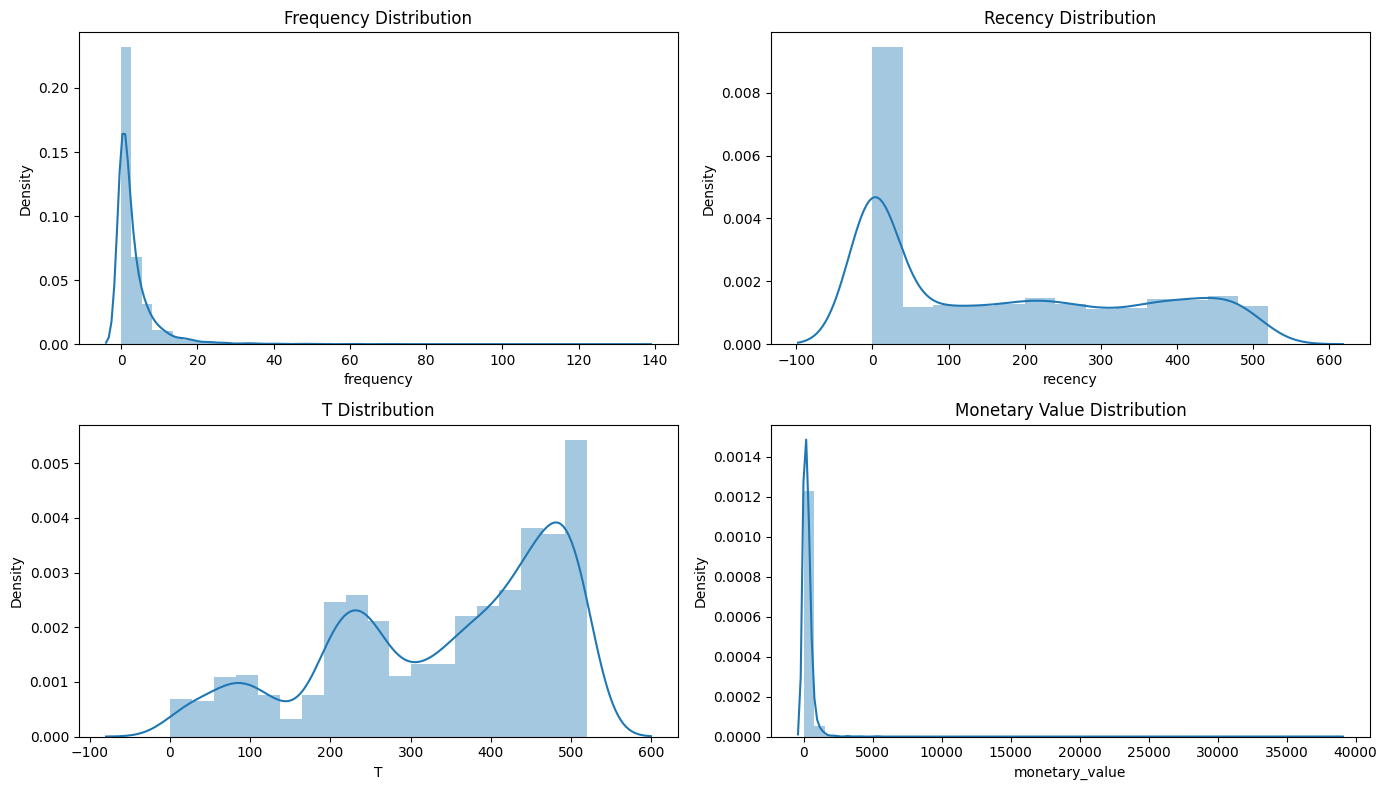

In [59]:
# PLOTTING THE DISTRIBUTION FOR THESE COLUMNS

plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
sns.distplot(rfm["frequency"])
plt.title("Frequency Distribution")

plt.subplot(2,2,2)
sns.distplot(rfm["recency"])
plt.title("Recency Distribution")

plt.subplot(2,2,3)
sns.distplot(rfm["T"])
plt.title("T Distribution")

plt.subplot(2,2,4)
sns.distplot(rfm["monetary_value"])
plt.title("Monetary Value Distribution")

plt.tight_layout()

In [60]:
rfm.describe()

frequency      recency            T  monetary_value
count  4451.000000  4451.000000  4451.000000     4451.000000
mean      3.528645   177.919793   342.069423      269.949833
std       7.110446   174.725083   142.226513      753.064103
min       0.000000     0.000000     0.000000        0.000000
25%       0.000000     0.000000   234.000000        0.000000
50%       1.000000   141.000000   380.000000      196.700000
75%       4.000000   337.500000   467.000000      358.110000
max     135.000000   520.000000   520.000000    38662.955000

In [61]:
#checking for the values containing zero.

print("Total Number of Zeros in Frequency column:", len(rfm[rfm["frequency"] == 0]))
print("Total Number of Zeros in Recency column:", len(rfm[rfm["recency"] == 0]))
print("Total Number of Zeros in Monetary Value column:", len(rfm[rfm["monetary_value"] == 0]))

Total Number of Zeros in Frequency column: 1481
Total Number of Zeros in Recency column: 1481
Total Number of Zeros in Monetary Value column: 1481


In [62]:
# INIT MODEL.

bgf = BetaGeoFitter(penalizer_coef = 0.0)

In [63]:
# FITTING THE MODEL

bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4451 subjects, a: 0.17, alpha: 65.03, b: 3.34, r: 0.68>


In [64]:
bgf.summary

coef  se(coef)  lower 95% bound  upper 95% bound
r       0.680240  0.020181         0.640686         0.719794
alpha  65.030870  2.414402        60.298642        69.763097
a       0.167976  0.034159         0.101023         0.234928
b       3.343937  0.986561         1.410279         5.277596

In BG/NBD model, two assumptions for incorporating heterogenity of transaction rate $\lambda$ and drop-out probability $p$ are:  
- $\lambda$ follows a gamma distribution  
- $p$ follows a beta distribution.  

Here we check the heterogenity of these two parameters.

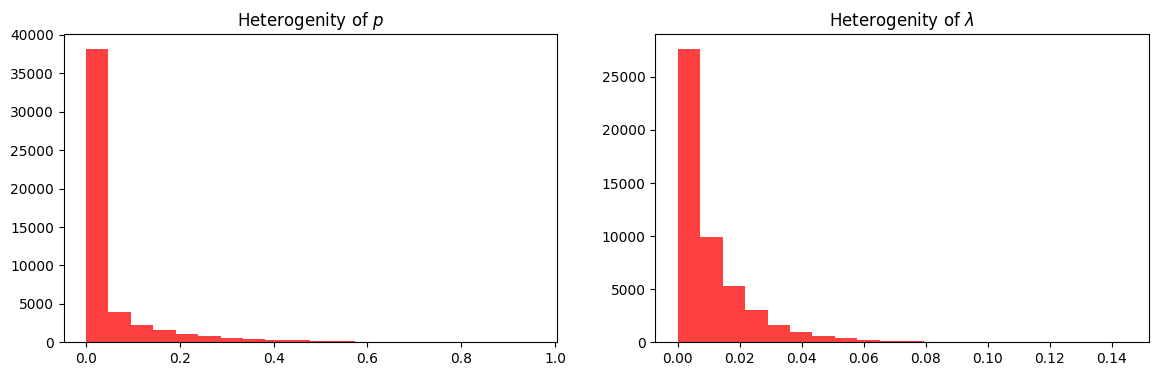

In [65]:
gbd = beta.rvs(bgf.params_['a'], bgf.params_['b'], size = 50000)
ggd = gamma.rvs(bgf.params_['r'], scale=1./bgf.params_['alpha'], size = 50000)

plt.figure(figsize=(14,4))

plt.subplot(121)
plt.title('Heterogenity of $p$')
plt.hist(gbd, 20, facecolor='red', alpha=0.75)

plt.subplot(122) 
plt.title('Heterogenity of $\lambda$')
plt.hist(ggd, 20, facecolor='red', alpha=0.75)

plt.show()

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

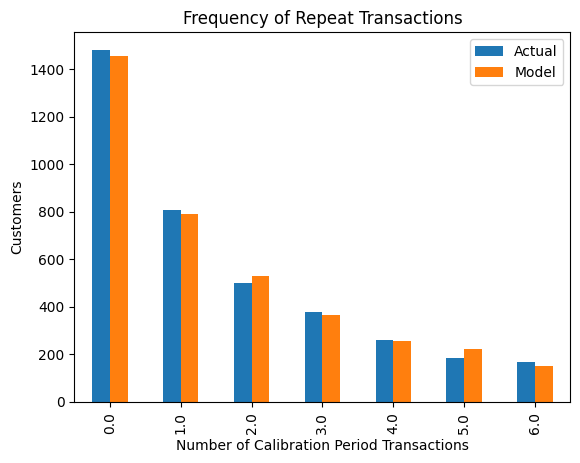

In [66]:
plot_period_transactions(bgf)

**MODEL FIT WITH HOLDOUT PERIOD**

In [67]:
# CALCULATE RFM FOR HOLDOUT PERIOD.

rfm_hold_out = lifetimes.utils.calibration_and_holdout_data(
    transactions = df, 
    customer_id_col = "Customer ID", 
    datetime_col = "InvoiceDate", 
    monetary_value_col = "TotalPrice",
    calibration_period_end = '2011-06-08',
    observation_period_end = '2011-12-09',
    freq = 'D'
)

rfm_hold_out

frequency_cal  recency_cal  T_cal  monetary_value_cal  \
Customer ID                                                          
12346                  2.0        322.0  463.0        38662.955000   
12608                  0.0          0.0  220.0            0.000000   
12745                  1.0         88.0  390.0          266.930000   
12746                  0.0          0.0  356.0            0.000000   
12747                 17.0        469.0  483.0          355.918235   
...                    ...          ...    ...                 ...   
18283                  9.0        458.0  474.0          119.496667   
18284                  0.0          0.0  247.0            0.000000   
18285                  0.0          0.0  476.0            0.000000   
18286                  0.0          0.0  292.0            0.000000   
18287                  3.0        370.0  387.0          679.793333   

             frequency_holdout  monetary_value_holdout  duration_holdout  
Customer ID                                                               
12346                      0.0                0.000000             184.0  
12608                      0.0                0.000000             184.0  
12745                      0.0                0.000000             184.0  
12746                      0.0                0.000000             184.0  
12747                      5.0               43.846042             184.0  
...                        ...                     ...               ...  
18283                      9.0                2.976775             184.0  
18284                      0.0                0.000000             184.0  
18285                      0.0                0.000000             184.0  
18286                      0.0                0.000000             184.0  
18287                      2.0               26.146341             184.0  

[4446 rows x 7 columns]

In [68]:
rfm_hold_out = rfm_hold_out.reset_index()
rfm_hold_out

Customer ID  frequency_cal  recency_cal  T_cal  monetary_value_cal  \
0          12346            2.0        322.0  463.0        38662.955000   
1          12608            0.0          0.0  220.0            0.000000   
2          12745            1.0         88.0  390.0          266.930000   
3          12746            0.0          0.0  356.0            0.000000   
4          12747           17.0        469.0  483.0          355.918235   
...          ...            ...          ...    ...                 ...   
4441       18283            9.0        458.0  474.0          119.496667   
4442       18284            0.0          0.0  247.0            0.000000   
4443       18285            0.0          0.0  476.0            0.000000   
4444       18286            0.0          0.0  292.0            0.000000   
4445       18287            3.0        370.0  387.0          679.793333   

      frequency_holdout  monetary_value_holdout  duration_holdout  
0                   0.0                0.000000             184.0  
1                   0.0                0.000000             184.0  
2                   0.0                0.000000             184.0  
3                   0.0                0.000000             184.0  
4                   5.0               43.846042             184.0  
...                 ...                     ...               ...  
4441                9.0                2.976775             184.0  
4442                0.0                0.000000             184.0  
4443                0.0                0.000000             184.0  
4444                0.0                0.000000             184.0  
4445                2.0               26.146341             184.0  

[4446 rows x 8 columns]

In [69]:
rfm_hold_out.shape

(4446, 8)

In [70]:
rfm_hold_out.head()

Customer ID  frequency_cal  recency_cal  T_cal  monetary_value_cal  \
0       12346            2.0        322.0  463.0        38662.955000   
1       12608            0.0          0.0  220.0            0.000000   
2       12745            1.0         88.0  390.0          266.930000   
3       12746            0.0          0.0  356.0            0.000000   
4       12747           17.0        469.0  483.0          355.918235   

   frequency_holdout  monetary_value_holdout  duration_holdout  
0                0.0                0.000000             184.0  
1                0.0                0.000000             184.0  
2                0.0                0.000000             184.0  
3                0.0                0.000000             184.0  
4                5.0               43.846042             184.0

**Search for best value of L2 coefficient.**

In [71]:
l2_coefs = [0.01, 0.05, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

l2_list = []
rmse_list = []

for coef in l2_coefs :

    # Fitting the model using the calibration dataset.
    model = BetaGeoFitter(penalizer_coef=coef)
    model.fit(rfm_hold_out['frequency_cal'], rfm_hold_out['recency_cal'], rfm_hold_out['T_cal'])

    # Predicting the frequency for the holdout period for all customers. 
    pred_freq = pd.DataFrame(model.predict(rfm_hold_out['duration_holdout'], rfm_hold_out['frequency_cal'], rfm_hold_out['recency_cal'], rfm_hold_out['T_cal']), columns=['pred_frequency']).reset_index()

    new_df = pd.concat([rfm_hold_out, pred_freq], axis=1).dropna()
    new_df = new_df.reset_index(drop=True)

    # Computing the rmse score 
    rmse_score = np.sqrt(mean_squared_error(new_df['frequency_holdout'], new_df['pred_frequency']))
    l2_list.append(coef)
    rmse_list.append(rmse_score)

# Getting the results 
search_results = pd.DataFrame(np.array(rmse_list), columns=['rmse_score']).merge(pd.DataFrame(np.array(l2_list), columns=['L2 coefs']), right_index=True, left_index=True)
search_results

rmse_score  L2 coefs
0    1.829322      0.01
1    1.733511      0.05
2    1.739391      0.09
3    1.741386      0.10
4    1.747198      0.30
5    1.751414      0.50
6    1.753782      0.70
7    1.756916      0.90
8    1.766862      1.00

**Fit model with Best Parameters**

In [72]:
rfm_hold_out.head()

Customer ID  frequency_cal  recency_cal  T_cal  monetary_value_cal  \
0       12346            2.0        322.0  463.0        38662.955000   
1       12608            0.0          0.0  220.0            0.000000   
2       12745            1.0         88.0  390.0          266.930000   
3       12746            0.0          0.0  356.0            0.000000   
4       12747           17.0        469.0  483.0          355.918235   

   frequency_holdout  monetary_value_holdout  duration_holdout  
0                0.0                0.000000             184.0  
1                0.0                0.000000             184.0  
2                0.0                0.000000             184.0  
3                0.0                0.000000             184.0  
4                5.0               43.846042             184.0

In [73]:
# INIT MODEL.

bgf = BetaGeoFitter(penalizer_coef = 0.05)

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

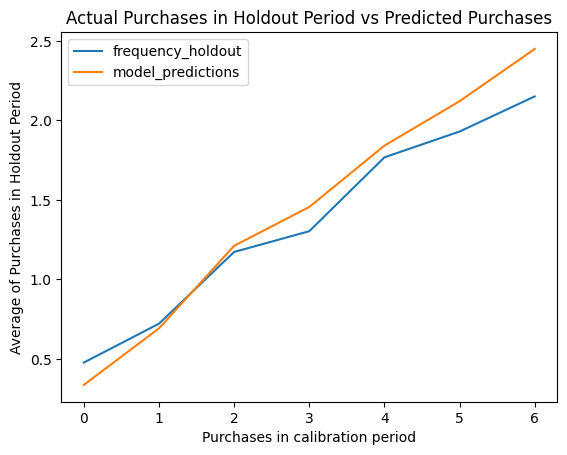

In [74]:
# MODEL FITTING ON '_cal' & TEST ON '_holdout' COLUMNS.

bgf.fit(rfm_hold_out['frequency_cal'], rfm_hold_out['recency_cal'], rfm_hold_out['T_cal']) 

plot_calibration_purchases_vs_holdout_purchases(bgf, rfm_hold_out)

The above plot groups all customers in the calibration period by their number of repeat purchases (x-axis) and then averages over their repeat purchases in the holdout period (y-axis). The green and blue line presents the model prediction and actual result of the y-axis respectively. 

As we can see, the model does a decent job while predicting the purchase behaviour in the holdout period. 

**Customer Probability Histories**

Given a customer's previous transactions, we can calculate their historical probability of being alive using the model.

<Axes: title={'center': 'History of P_alive'}, ylabel='P_alive'>

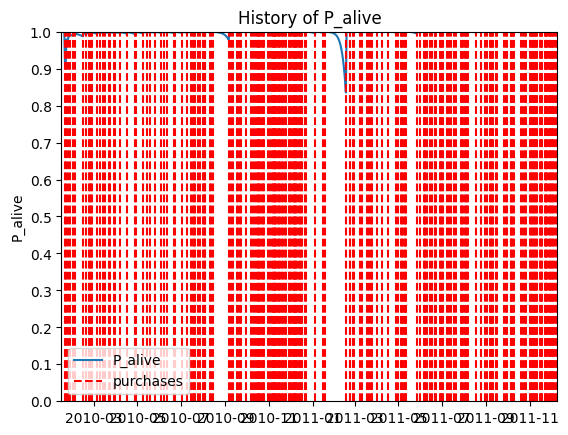

In [75]:
cust_id = '12748'
days_since_birth = 200
sp_trans = df.loc[df['Customer ID'] == cust_id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

**RECREATE THE RFM MATRIX ON WHOLE DATA & REFIT THE MODEL FOR FORECASTING.**

In [76]:
rfm = lifetimes.utils.summary_data_from_transaction_data(
    transactions = df, 
    customer_id_col = "Customer ID", 
    datetime_col = "InvoiceDate", 
    monetary_value_col = "TotalPrice",
    observation_period_end = '2011-12-09',
    freq = 'D'
)

rfm.head()

frequency  recency      T  monetary_value
Customer ID                                           
12346              2.0    322.0  647.0    38662.955000
12608              0.0      0.0  404.0        0.000000
12745              1.0     88.0  574.0      266.930000
12746              0.0      0.0  540.0        0.000000
12747             22.0    665.0  667.0      370.691818

In [77]:
rfm = rfm.reset_index()
rfm.head()

Customer ID  frequency  recency      T  monetary_value
0       12346        2.0    322.0  647.0    38662.955000
1       12608        0.0      0.0  404.0        0.000000
2       12745        1.0     88.0  574.0      266.930000
3       12746        0.0      0.0  540.0        0.000000
4       12747       22.0    665.0  667.0      370.691818

In [78]:
# INIT MODEL.

bgf_model = BetaGeoFitter(penalizer_coef = 0.05)

In [79]:
bgf_model.fit(rfm['frequency'], rfm['recency'], rfm['T'])

<lifetimes.BetaGeoFitter: fitted with 5265 subjects, a: 0.03, alpha: 56.56, b: 0.32, r: 0.60>

In [80]:
# PREDICTING FORECAST COUNTS FOR EACH CUSTOMER IN THE NEXT 180 days.

t = 180

rfm['predicted_purchases'] = bgf_model.conditional_expected_number_of_purchases_up_to_time(t, rfm['frequency'], rfm['recency'], rfm['T'])
rfm = rfm.dropna()
rfm.sample(10)

Customer ID  frequency  recency      T  monetary_value  \
10         12821        1.0    397.0  611.0       92.720000   
655        13495        7.0    619.0  626.0      594.821429   
90         12906        1.0     67.0   78.0      983.220000   
2700       15629        2.0     82.0  532.0      532.350000   
4841       17854        3.0    329.0  514.0      267.423333   
3763       16730        2.0    267.0  319.0      278.045000   
130        12948        6.0    248.0  264.0      282.191667   
1512       14391        0.0      0.0  576.0        0.000000   
3717       16682        4.0    183.0  187.0      125.625000   
3971       16942        7.0    215.0  227.0      233.650000   

      predicted_purchases  
10               0.369243  
655              1.986806  
90               1.902959  
2700             0.413000  
4841             1.076228  
3763             1.198098  
130              3.650032  
1512             0.168200  
3717             3.333742  
3971             4.754029

In [81]:
# GET RESULTS FOR TOP 10 CUSTOMERS

best_projected_cust = rfm.sort_values(['predicted_purchases'], ascending=False).head(10)
best_projected_cust

Customer ID  frequency  recency      T  monetary_value  \
5          12748      195.0    694.0  694.0      280.087590   
4829       17841      185.0    703.0  704.0      365.553514   
2393       15311      181.0    703.0  703.0      587.957403   
1720       14606      173.0    702.0  703.0      167.557977   
265        13089      126.0    696.0  698.0      896.614921   
1645       14527      113.0    702.0  704.0      190.978053   
153        12971       97.0    697.0  700.0      161.844742   
948        13798       95.0    703.0  704.0      774.007263   
3467       16422       91.0    679.0  696.0      694.564505   
2127       15039       79.0    681.0  690.0      495.722405   

      predicted_purchases  
5               46.754383  
4829            43.780227  
2393            42.894571  
1720            41.002889  
265             30.095943  
1645            26.792384  
153             23.137899  
948             22.546979  
3467            21.784834  
2127            19.112723

In [82]:
# TOTAL COUNT IN PAST ~23 MONTHS FOR TOP CUSTOMERS.

df["Customer ID"].value_counts().head(10)

17841    12353
12748     7142
14606     6257
14096     5111
15311     4121
13089     3317
16549     3250
14298     2825
15039     2743
17850     2537
Name: Customer ID, dtype: int64

#### **Gamma Gamma model training**

Till now we didn’t take into account the economic value of each transaction & only focused on transaction occurrences.  
To estimate economic value of each transaction, we can use the Gamma-Gamma model.  

**Note:**  
We will only study customers with repeat purchases.  
Also, this model assumes that there is no relationship between the monetary value and the purchase frequency.  
So, we check the correlation between these two features. 

In [83]:
rfm.head()

Customer ID  frequency  recency      T  monetary_value  predicted_purchases
0       12346        2.0    322.0  647.0    38662.955000             0.598224
1       12608        0.0      0.0  404.0        0.000000             0.229928
2       12745        1.0     88.0  574.0      266.930000             0.236734
3       12746        0.0      0.0  540.0        0.000000             0.178209
4       12747       22.0    665.0  667.0      370.691818             5.595243

In [84]:
rfm.shape

(4917, 6)

In [85]:
# TAKE CUSTOMERS WITH REPEAT PURCHASES. 
rfm_mod = rfm[(rfm['frequency'] > 0) & (rfm['monetary_value'] > 0)] 
rfm_mod.shape

(3752, 6)

In [86]:
# FIT BGF MODEL.

bgf_model = BetaGeoFitter(penalizer_coef = 0.05)
bgf_model.fit(rfm_mod['frequency'], rfm_mod['recency'], rfm_mod['T'])
bgf_model

<lifetimes.BetaGeoFitter: fitted with 3752 subjects, a: 0.05, alpha: 73.43, b: 0.38, r: 1.09>

In [87]:
# CHECK FOR CORRELATION

rfm_mod[['monetary_value','frequency']].corr()

monetary_value  frequency
monetary_value        1.000000   0.015361
frequency             0.015361   1.000000

In [88]:
ggf_model = GammaGammaFitter(penalizer_coef = 0)
ggf_model.fit(rfm_mod['frequency'], rfm_mod['monetary_value'])
ggf_model

<lifetimes.GammaGammaFitter: fitted with 3752 subjects, p: 2.21, q: 3.86, v: 500.21>

In [89]:
# predict the spending using the Gamma-Gamma model

rfm_mod["expected_average_profit"] = ggf_model.conditional_expected_average_profit(rfm_mod["frequency"], rfm_mod["monetary_value"])
rfm_mod

Customer ID  frequency  recency      T  monetary_value  \
0          12346        2.0    322.0  647.0    38662.955000   
2          12745        1.0     88.0  574.0      266.930000   
4          12747       22.0    665.0  667.0      370.691818   
5          12748      195.0    694.0  694.0      280.087590   
6          12749        6.0    518.0  521.0     1010.743333   
...          ...        ...      ...    ...             ...   
5257       18280        1.0    117.0  394.0      180.600000   
5258       18281        1.0    397.0  577.0       80.820000   
5259       18282        1.0    119.0  126.0       77.840000   
5260       18283       18.0    655.0  658.0      146.405556   
5264       18287        5.0    529.0  571.0      622.276000   

      predicted_purchases  expected_average_profit  
0                0.598224             23640.334529  
2                0.236734               334.690775  
4                5.595243               371.603895  
5               46.754383               280.792218  
6                2.036215               900.245482  
...                   ...                      ...  
5257             0.452696               297.026468  
5258             0.393320               253.494156  
5259             1.417933               252.194033  
5260             4.660953               162.528346  
5264             1.583905               573.989128  

[3752 rows x 7 columns]

In [90]:
# compute the CLV for the next six months for each customer

rfm_mod['CLV'] = ggf_model.customer_lifetime_value(
    bgf_model,
    rfm_mod['frequency'],
    rfm_mod['recency'],
    rfm_mod['T'],
    rfm_mod['monetary_value'],
    time = 6, # In months 
    freq = "D",
    discount_rate = 0.01
)

rfm_mod 

Customer ID  frequency  recency      T  monetary_value  \
0          12346        2.0    322.0  647.0    38662.955000   
2          12745        1.0     88.0  574.0      266.930000   
4          12747       22.0    665.0  667.0      370.691818   
5          12748      195.0    694.0  694.0      280.087590   
6          12749        6.0    518.0  521.0     1010.743333   
...          ...        ...      ...    ...             ...   
5257       18280        1.0    117.0  394.0      180.600000   
5258       18281        1.0    397.0  577.0       80.820000   
5259       18282        1.0    119.0  126.0       77.840000   
5260       18283       18.0    655.0  658.0      146.405556   
5264       18287        5.0    529.0  571.0      622.276000   

      predicted_purchases  expected_average_profit           CLV  
0                0.598224             23640.334529  14448.123148  
2                0.236734               334.690775     58.817741  
4                5.595243               371.603895   1999.297768  
5               46.754383               280.792218  12409.595206  
6                2.036215               900.245482   1836.341399  
...                   ...                      ...           ...  
5257             0.452696               297.026468    128.199754  
5258             0.393320               253.494156    113.487869  
5259             1.417933               252.194033    395.218463  
5260             4.660953               162.528346    731.327376  
5264             1.583905               573.989128    921.635439  

[3752 rows x 8 columns]